# ML4DS - Model Selection

## Introduction

You will explore the various options for model selection on a *clustering* task.

In the first section, you will use synthetic data, where we know the true number of clusters. In the second (which will make up the assessed task), you will compare multiple methods for model selection on a real dataset.

## Import Packages

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import itertools
from scipy import linalg
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
from pandas.plotting import scatter_matrix as sm

# Part 1: synthetic data

### Generate some data

Make data from a mixture of gaussians using sklearn `make_blobs` method. Try experimenting with:
- The number of centers
- the `cluster_std`
- The total number of samples

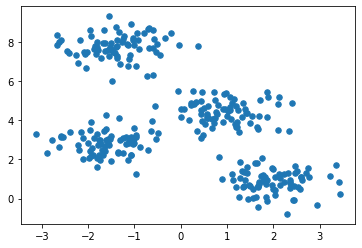

In [167]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.6, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=30);

# Clustering - K-Means Example

Using the `KMeans` model, try and optimise, plot a graph of $K$ versus the `inertia_` value of the clustering. The `inertia_` value is the quantity that is minimised when K-means is training: the total sum of squared errors between the observations and the cluster centre to which they are assigned.

__Question__: what do you notice about this curve? Do you think you could use it to choose the correct number of clusters? See e.g. https://en.wikipedia.org/wiki/Elbow_method_(clustering). What happens when you vary the parameters used to generate the data (above)

__Question__ Choose K using the Elbow Method

__Question__: using the value of $K$ you have chosen, fit the clustering and then use the following code to plot the data coloured by cluster assignment. You can get the cluster assignment using the following code:
`y_kmeans = kmeans.predict(X)`

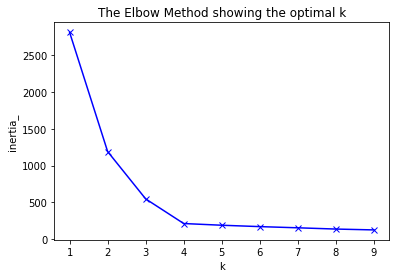

In [168]:
from scipy.spatial.distance import cdist

# k means determine k
inertia = []

K = range(1,10)
for k in range(1,10):
    kmean = KMeans(n_clusters=k).fit(X)
    kmean.fit(X)
    inertia.append(kmean.inertia_)
# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia_')
plt.title('The Elbow Method showing the optimal k')
plt.show()



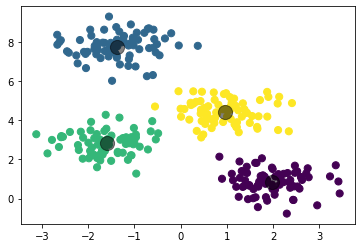

In [169]:
K = 4
kmean = KMeans(n_clusters=K).fit(X)
y_kmeans = kmean.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmean.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### Silhouette Score for K for K-Means

The silhouette score (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) is a method for optimising $K$ in a clustering setting. It computes how similar objects are to other objects within their cluster compared to how similar they are to points in neighbouring clusters.

__Question__: make a plot of Silhouette scores for the example data above. Vary the data generation parameters. Does the optimal $K$ from Silhouette agree with that from inspecting the inertia?

For n_clusters = 2 The average silhouette_score is : 0.5426422297358302
For n_clusters = 3 The average silhouette_score is : 0.5890390393551768
For n_clusters = 4 The average silhouette_score is : 0.6819938690643478
For n_clusters = 5 The average silhouette_score is : 0.5923875148758644
For n_clusters = 6 The average silhouette_score is : 0.49934504405927566


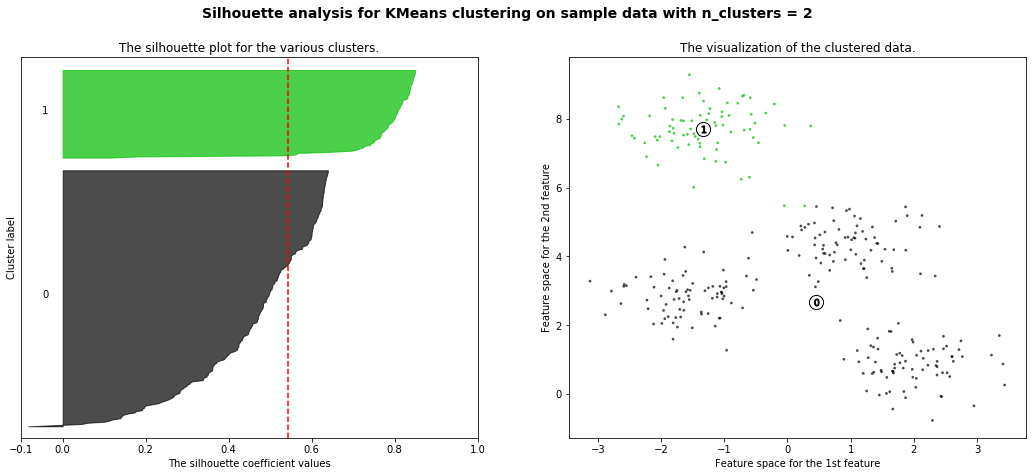

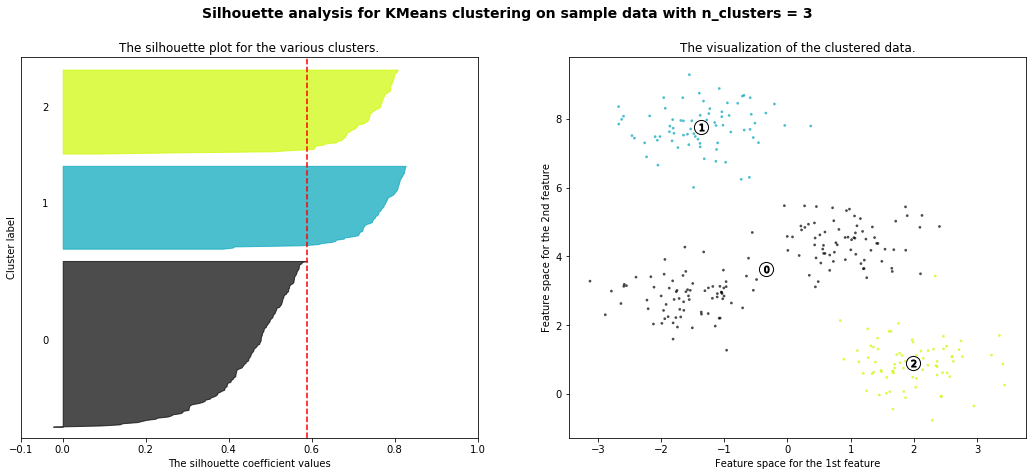

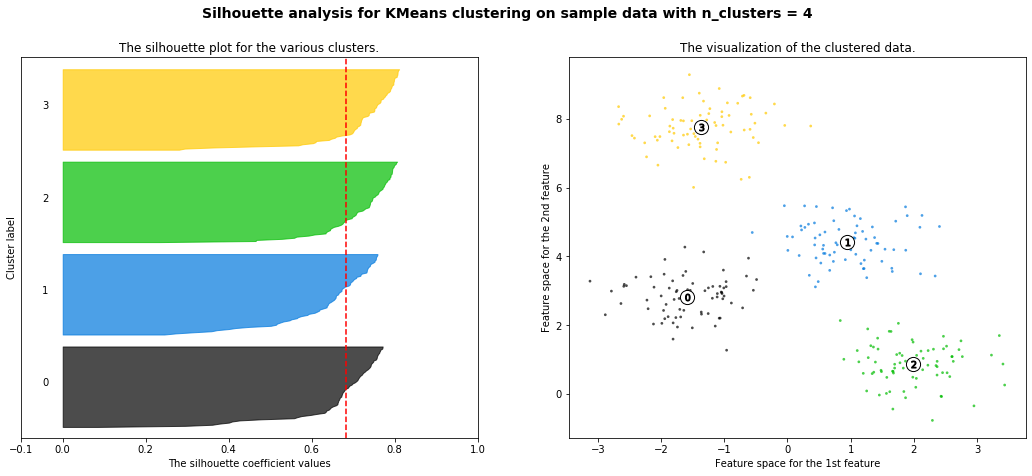

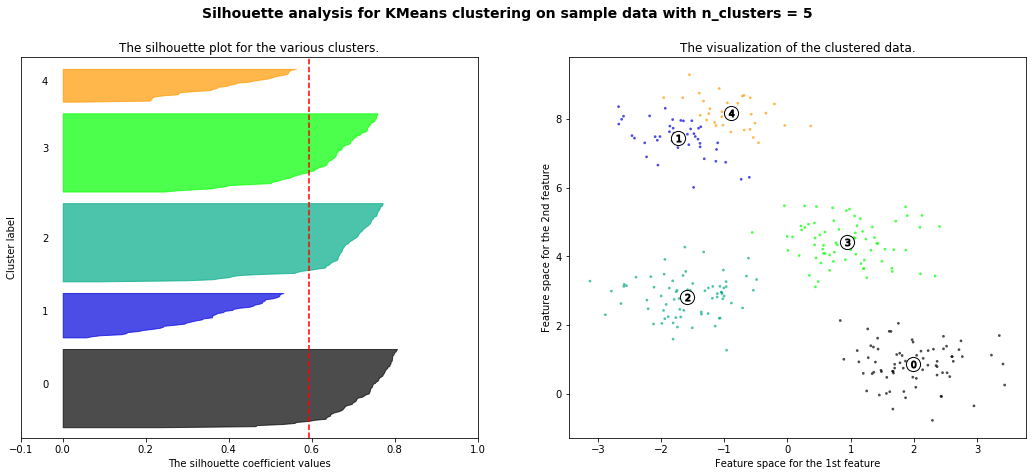

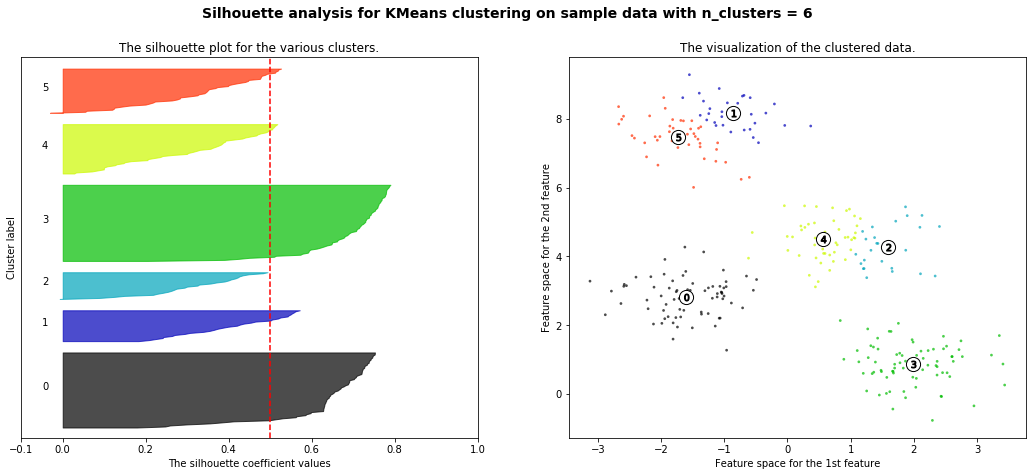

In [170]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## BIC for K-means

Although K-means is not optimised by maximising the likelihood, you can compute a quanitity that is interpretable as BIC. To do this, compute:

$KD\ln(N) - E$

where $E$ is the negative of the `inertia_` property of K-means, and $D$ is the dimension of the data (in our case, 2).

__Question:__ for the data above, plot BIC for K-means as a function of $K$ for $K$ varying from 1 to 30. Does it agree with the previous answers?


Text(0, 0.5, '# BIC')

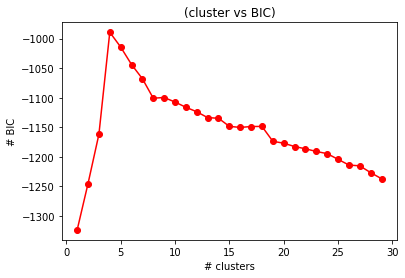

In [171]:
from past.builtins import xrange
from scipy.spatial import distance
from sklearn import cluster

def compute_bic(kmean,X):
    
    # assign centers and labels
    centers = [kmean.cluster_centers_]
    labels  = kmean.labels_
    #number of clusters
    m = kmean.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
           n[i] * np.log(N) -
         ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
          ((n[i] - 1) * d/2) for i in xrange(m)]) - const_term

    return(BIC)


ks = range(1,30)


KMeans = [cluster.KMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [compute_bic(kmeansi,X) for kmeansi in KMeans]

plt.plot(ks,BIC,'r-o')
plt.title("(cluster vs BIC)")
plt.xlabel("# clusters")
plt.ylabel("# BIC")



# Mixture Models

Statistical mixture models are somewhat related to K-means but place the clustering problem within a statistical framework.

We will use Gaussian mixtures: models in which data from each cluster is assumed to come from a different Gaussian. With mixture models we have two model selection challenges: choosing $K$ and choosing the form of the Gaussian covariance matrices:

- spherical: the covariance matrices are of the form $\sigma^2\mathbf{I}$ (where $\mathbf{I}$ is an identity), i.e. the variance is the same in all dimensions and there is no correlation structure
- diagonal: there is no correlation structure, but the variance can be different in each dimension
- tied: all Gaussians share the same covariance matrix
- full: each Gaussian can have a different covariance matrix that can have full correlation structure

See https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html

To create a Gaussian mixture object using sklearn with (say) a tied covariance structure, use:

```{python}
from sklearn import mixture
gmm = mixture.Gaussian(n_components = K,covariance_type='cv_type')
```

__Note__
- the `mixture.Gaussian` object has methods to compute BIC and AIC (`gmm.bic(X)` etc)
- you can also perform cross validation with a mixture, but computing the likelihood on held-out observations. The likelihood is the standard mixture likelihood:

$L = \prod_n \sum_k \pi_k p(x_n|k)$

where the product is over the held-out data, the sum is over the clusters, $\pi_k$ is the prior weight of cluster k (`gmm.weights_`) and $p(x_n|k)$ is the Gaussian likelihood of the nth observation in the kth cluster.

## Additional imports...

In [172]:
import numpy as np
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from sklearn import mixture



### Load a real data set

In [173]:
digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target
print(n_samples)
print(n_digits)
print(labels)

1797
10
[0 1 2 ... 8 9 8]


### Useful code to plot a single digit

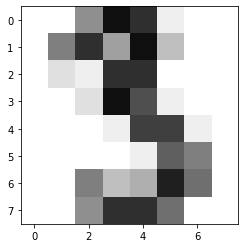

In [174]:
# method to plot a single digit
def plot_digit(digit_data):
    im = plt.imshow(digit_data.reshape(8,8), cmap='binary')
    im.set_clim(0, 16)

# example - plot the third one in the dataset    
plot_digit(digits.data[3])

### Project the data into 2D

In [175]:
reduced_data = PCA(n_components=2).fit_transform(data)

([], <a list of 0 Text yticklabel objects>)

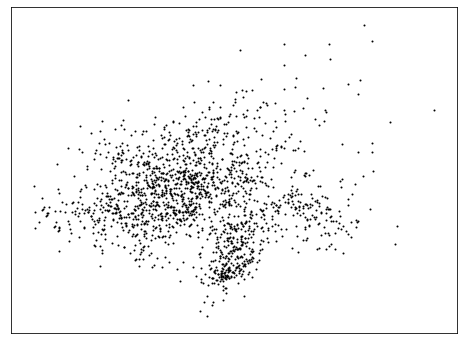

In [176]:
plt.figure(figsize=(8, 6))
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

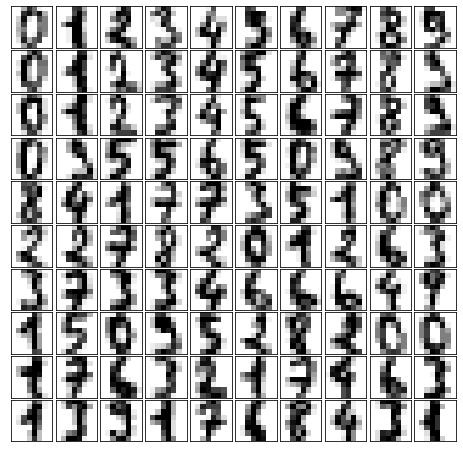

In [177]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

## The task

Explore different model selection strategies to determine the number of clusters required for a Gaussian mixture clustering of this data (in the 2D PCA space) **and** the correct choice of covariance matrix structure (from the options listed above).

You should try multiple methods (BIC, AIC, Silhouette, and cross-validation)

Explore the clusterings suggested by each method, and look to see which digits are being grouped or split (if the optimal number is not 10 (digits 0-9).

The following method might be useful to plot the result of the clustering(s) and nice covariance ellipses

In [178]:
from matplotlib.patches import Ellipse
colors = ['navy', 'turquoise', 'darkorange','red'] # will need to add other colours here if more clusters
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
            
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

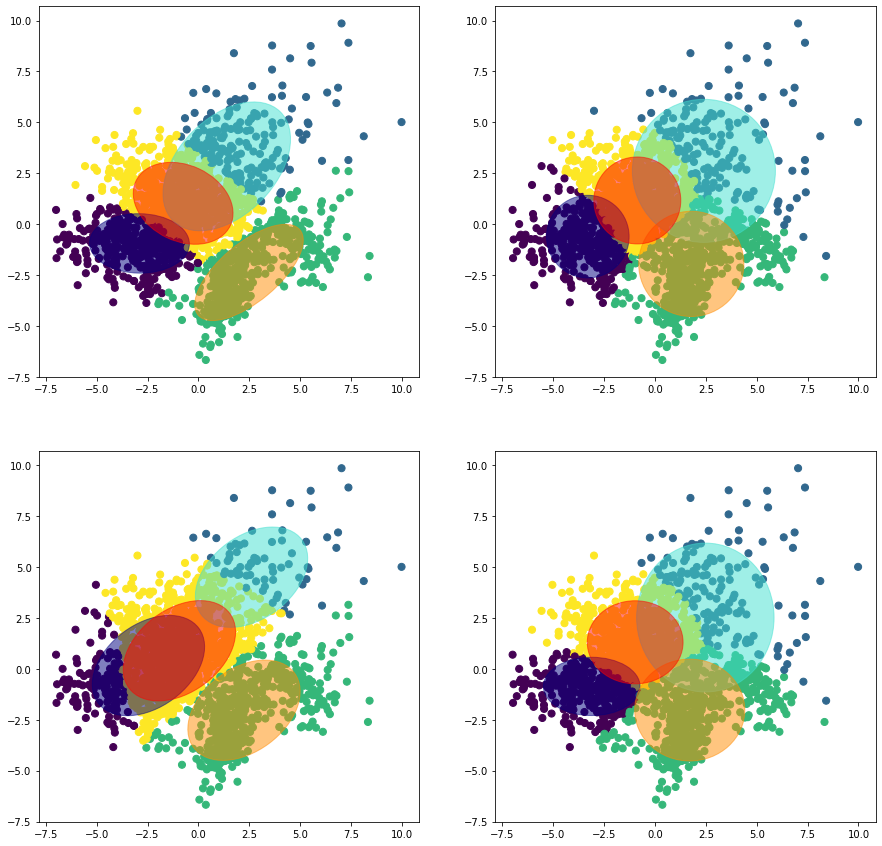

In [179]:
plt.subplots(2,2,figsize=(15,15))
cov_types = ['full', 'spherical', 'tied', 'diag']
i=1

for cov_type in cov_types:
    model = GaussianMixture(n_components=4, covariance_type=cov_type, random_state=0) 
    gmm = model.fit(reduced_data)
    plt.subplot(2,2,i)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=gmm.predict(reduced_data), s=50, cmap='viridis')
    make_ellipses(gmm, plt.gca())
    i+=1

{1: 16960.361548650828, 2: 16775.82811172039, 3: 16595.938264644377, 4: 16309.74708649448, 5: 16300.218565920994, 6: 16293.651392036918, 7: 16287.88615027967, 8: 16287.216896959637, 9: 16262.63743964929, 10: 16248.224565111312, 11: 16256.391759323427, 12: 16268.955321763005, 13: 16262.021716724863, 14: 16267.504965496444}


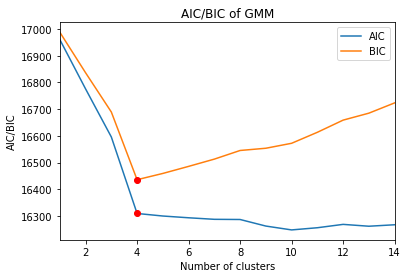

In [180]:
seed = np.random.seed(0)
aic = dict()
bic = dict()
for k in range(1,15):
    estimator = GaussianMixture(n_components = k, random_state=seed)
    res = estimator.fit(reduced_data)
    ic1 = estimator.aic(reduced_data)
    ic2 = estimator.bic(reduced_data)
    aic[k] = ic1
    bic[k] = ic2
   
aic_df = pd.Series(aic)
bic_df = pd.Series(bic)

temp = {'AIC' : aic_df,
     'BIC' : bic_df}
ic_df = pd.DataFrame(temp)
ax = ic_df.plot(title='AIC/BIC of GMM')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('AIC/BIC')
plt.plot(4,aic_df[4],'ro')
plt.plot(4,bic_df[4],'ro')
print(aic)


Automatically created module for IPython interactive environment


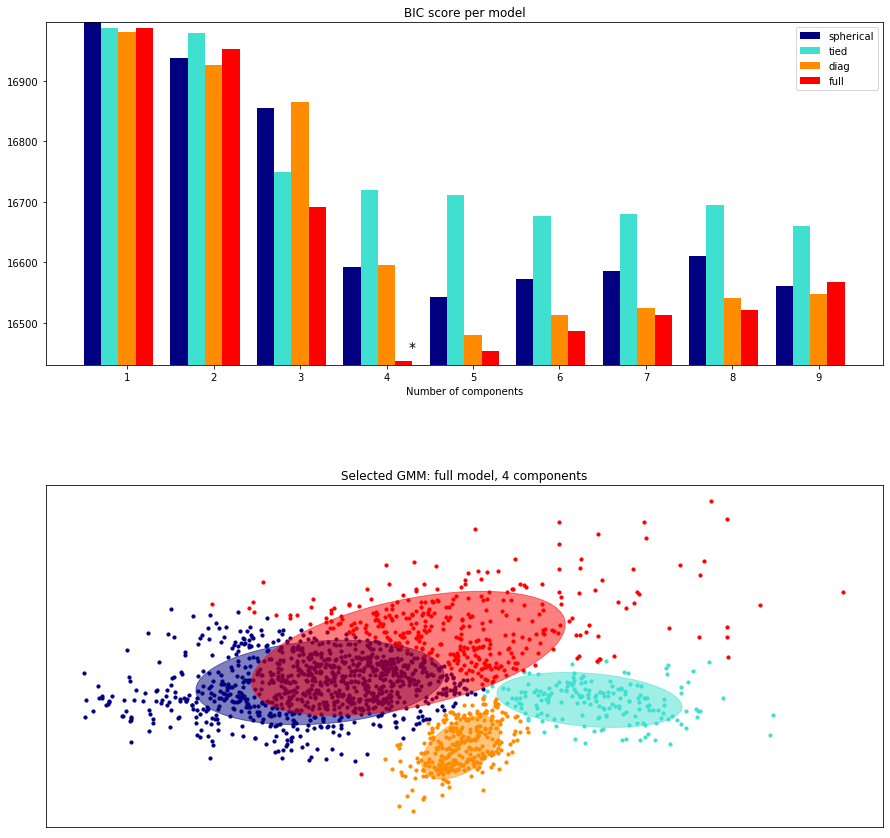

In [181]:
print(__doc__)

# Number of samples per component
#n_samples = 500

# Generate random sample, two components
np.random.seed(0)
#C = np.array([[0., -0.1], [1.7, .4]])
#X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
#          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(reduced_data)
        bic.append(gmm.bic(reduced_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'darkorange','red'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(15, 13))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(reduced_data)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = np.linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(reduced_data[Y_ == i, 0], reduced_data[Y_ == i, 1], s=10, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 4 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()



Automatically created module for IPython interactive environment


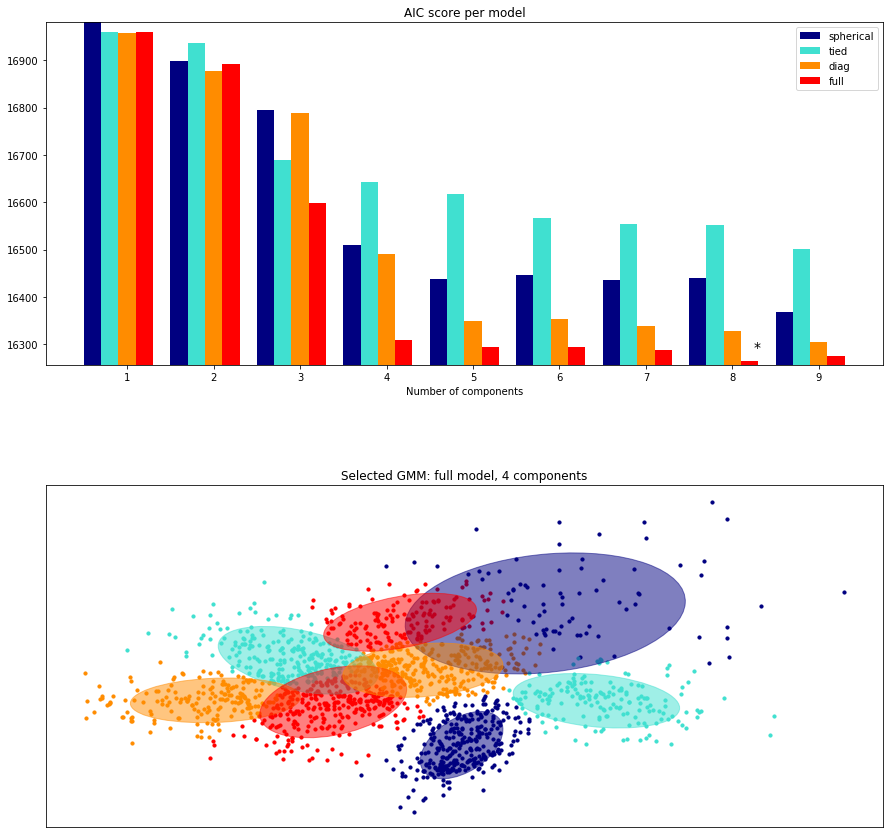

In [182]:
print(__doc__)

# Number of samples per component
#n_samples = 500

# Generate random sample, two components
np.random.seed(0)
#C = np.array([[0., -0.1], [1.7, .4]])
#X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
#          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

lowest_aic = np.infty
aic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(reduced_data)
        aic.append(gmm.aic(reduced_data))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm = gmm
            
aic = np.array(aic)
color_iter = itertools.cycle(['navy', 'turquoise', 'darkorange','red'])
clf = best_gmm
bars = []


plt.figure(figsize=(15, 13))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, aic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - .01 * aic.max(), aic.max()])
plt.title('AIC score per model')
xpos = np.mod(aic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(aic.argmin() / len(n_components_range))
plt.text(xpos, aic.min() * 0.97 + .03 * aic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(reduced_data)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(reduced_data[Y_ == i, 0], reduced_data[Y_ == i, 1], s=10, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 4 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()



For n_clusters = 2 The average silhouette_score is : 0.3476895023807514
For n_clusters = 3 The average silhouette_score is : 0.3960150355799594
For n_clusters = 4 The average silhouette_score is : 0.3529201048480304
For n_clusters = 5 The average silhouette_score is : 0.3468605001901759
For n_clusters = 6 The average silhouette_score is : 0.36660053490024996
For n_clusters = 7 The average silhouette_score is : 0.3733321322620479
For n_clusters = 8 The average silhouette_score is : 0.34614584277142485
For n_clusters = 9 The average silhouette_score is : 0.34462918995872993
For n_clusters = 10 The average silhouette_score is : 0.3572069921441318


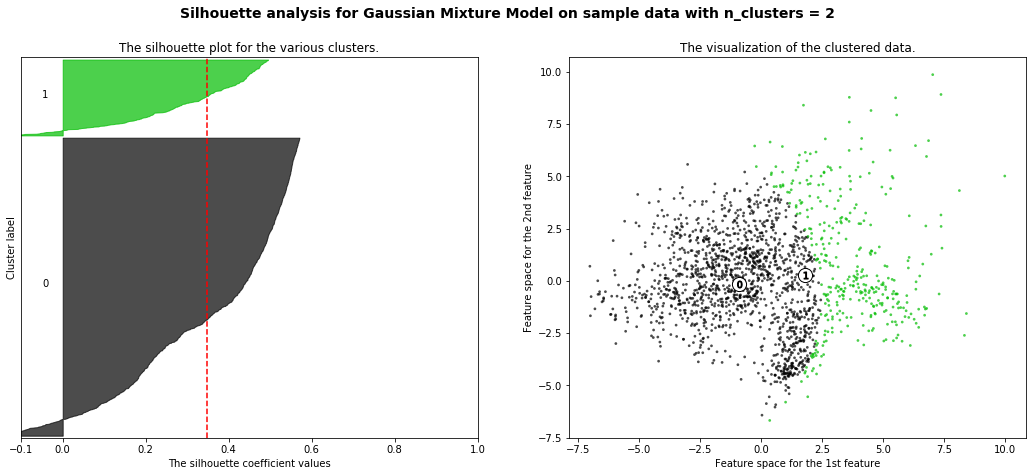

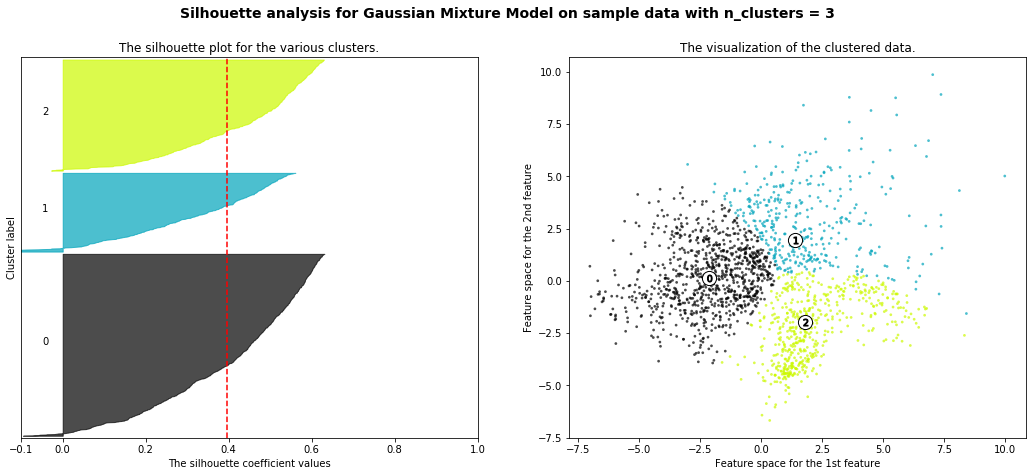

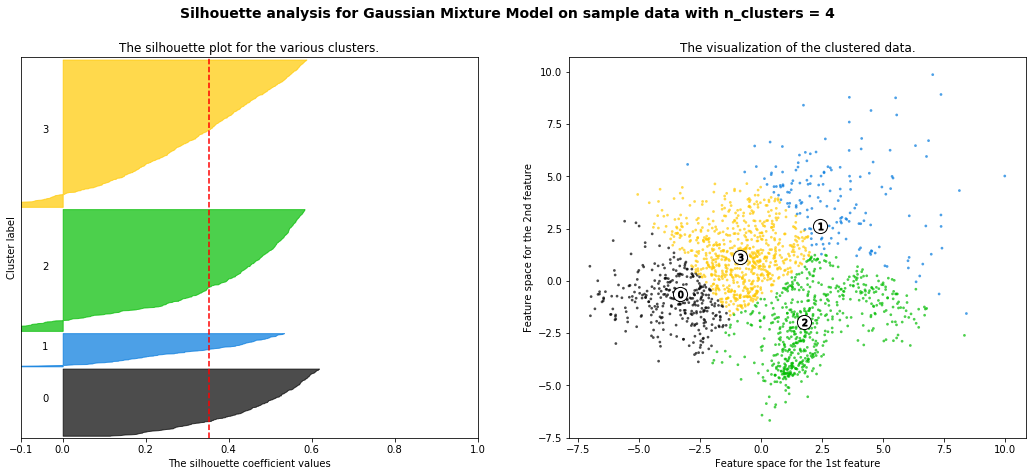

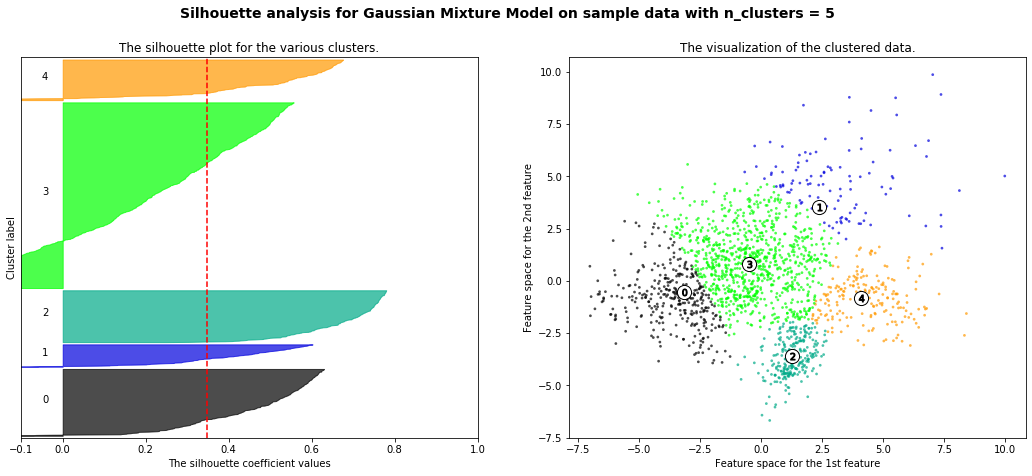

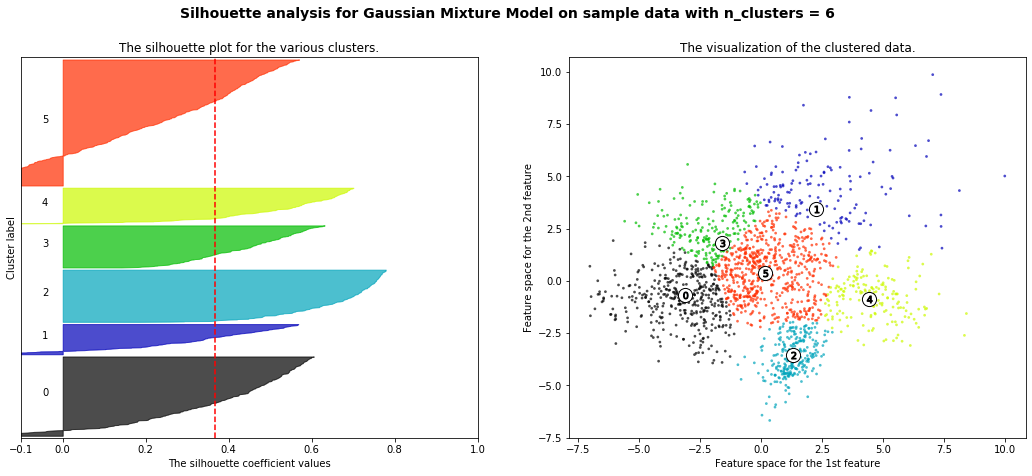

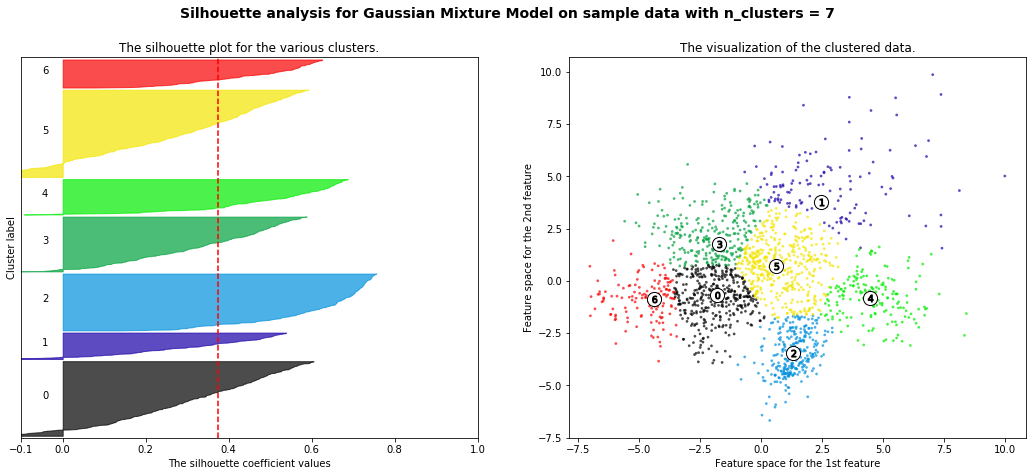

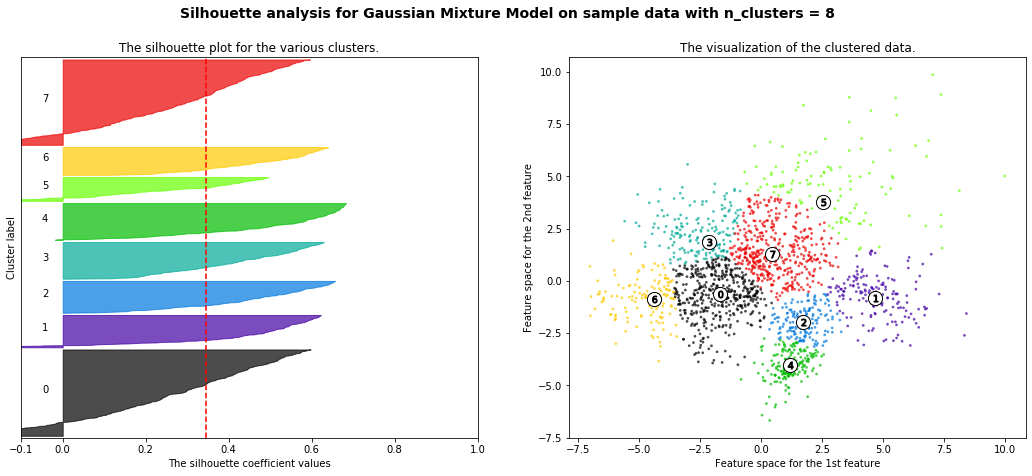

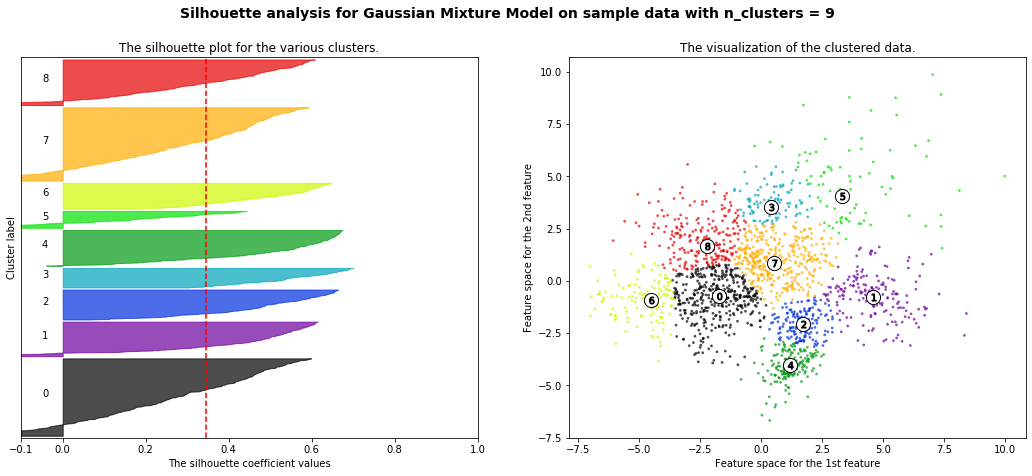

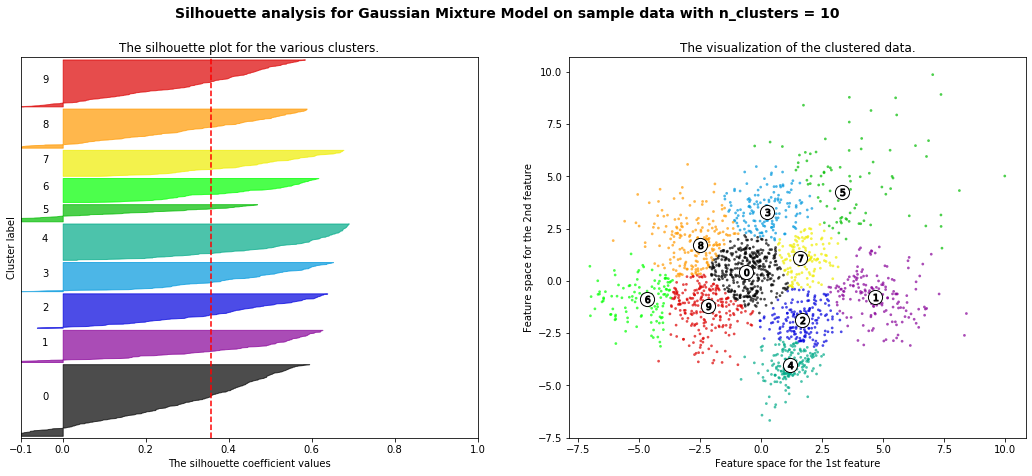

In [183]:
range_n_clusters = [2,3,4,5,6,7,8,9,10]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])
    
    
    clusterer = GaussianMixture(n_clusters, covariance_type='spherical', random_state=0)
    cluster_labels = clusterer.fit_predict(reduced_data)
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.means_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for Gaussian Mixture Model on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

[0.38363535136630134, 0.38435593705035465, 0.37083199637878206, 0.36457715849190175]
[0.36088094897037704, 0.3955637043366916, 0.3529596026153462, 0.35380286762719915]
[0.35687137475680225, 0.39400522332629645, 0.3693195406823062, 0.3653581325662925]
[0.34360076879836726, 0.3852310950309824, 0.3721357106331305, 0.3762427379622092]


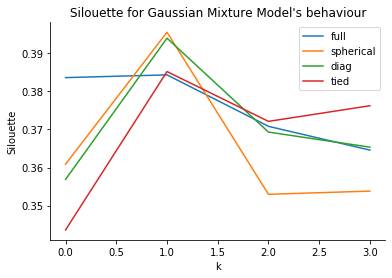

In [184]:
import seaborn as sns
s=[]
seed=np.random.seed(10)
range_n_clusters = range(2,6)
cv_types = ['full','spherical','diag','tied']
for cv_type in cv_types:
    for n_clusters in range_n_clusters:
        clusterer = GaussianMixture(n_clusters, covariance_type=cv_type, random_state=seed)
        cluster_labels = clusterer.fit_predict(reduced_data)
        centers = clusterer.means_
        s.append(silhouette_score(reduced_data, cluster_labels,  metric='euclidean'))
    print(s)
    plt.plot(s)
    plt.ylabel("Silouette")
    plt.xlabel("k")
    plt.title("Silouette for Gaussian Mixture Model's behaviour")
    sns.despine()
    plt.legend(cv_types)
    i+=1
    s=[]
  

['spherical' 'tied' 'diag' 'full']
[4 2 1 2]


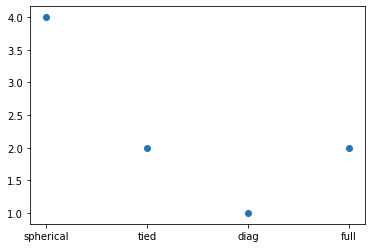

In [185]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

tuned_parameters = {'covariance_type': np.array(['spherical', 'tied', 'diag', 'full'])}
clf = GridSearchCV(GaussianMixture(random_state=10),tuned_parameters,cv=10)
clf.fit(reduced_data)
print(clf.cv_results_['param_covariance_type'])
print(clf.cv_results_['rank_test_score'])
plt.scatter(clf.cv_results_['param_covariance_type'],\
            clf.cv_results_['rank_test_score'])

-4.509983153909129


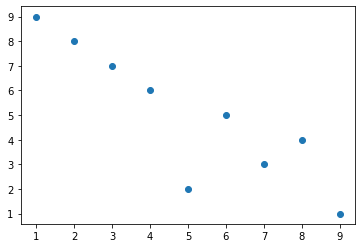

In [186]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
np.random.seed(2019)


n_components = {'n_components': np.arange(1,10,1)}
#construct grid search object that uses 4 fold cross validation
clf = GridSearchCV(GaussianMixture(covariance_type='diag',random_state=0),n_components,cv=4,)
#fit the data
clf.fit(reduced_data)
print(clf.score(reduced_data))

#plot the number of Gaussians against their rank
plt.scatter(clf.cv_results_['param_n_components'],\
            clf.cv_results_['rank_test_score'])

In [187]:
np.exp(gmm.score(reduced_data))

0.011120313691758818